In [1]:
import pandas as pd 
import numpy as np
from pandas_datareader import data, wb
import pandas_datareader as pdr
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import datetime
import math
import stock_cache # local module
fdr.__version__

'0.9.31'

TODO
* 400개 종목으로 테스트
* 액면 분할시? 이상한 종가 종목 찾기-anomaly, outlier
* 백테스트 라이브러리화

LTHM
* 필터
  직전 20일 기준 일평균 거래 금액이 5000만 달러 초과 - 20일 평균 거래 금액 필요
  최소 주가 5달러 (완료)
* 설정
  S&P500 종가가 100일 이동평균선 위에 있어야 함
  종목의 25일 이동평균 종가가 50일 이동평균 종가보다 높아야 함 (완료)
* 순위
  200일 동안 가장 높은 수익률 순으로 순위 부여 (완료)
* 포지션
  최대 10개 포지션, 포지션별 총자산 대비 2% 위험, 총자산 대비 최대 10% 자산 배분
* 손절매
  매수당일 체결 가격을 기준으로 직전 20일 ATR(Average Trade Range)의 5배 위의 지점
* 수익보호
  25% 추격 역지정가 (주가가 상승하면 추격 역지정가 상승)
* 기타
** 포지션 매도후 다시 매수 발생하려면 gold cross가 발생하여야 함. gold cross이후 up trend 상태에서 매수하지 않음. rebalance한다고 생각하고 매수해야 할까?

# 테스트 코드

## Dictionary append

In [53]:
ticker_dict = { }
ticker_dict["005930.KS"] = { "code": "005930.KS", "name": "Samsung"}
for k, v in ticker_dict.items():
    k = code
    print(k, v)

051900.KS {'code': '005930.KS', 'name': 'Samsung'}


## DataFrame append

In [489]:
dates = pd.date_range("20130101", periods=6)
print(type(dates[0]))
df = pd.DataFrame(columns=['A', 'B'])
for i in range(5):
    df = df.append(pd.Series({'A':i, 'B':i}, index=df.columns, name=dates[i]))
df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,A,B
2013-01-01,0,0
2013-01-02,1,1
2013-01-03,2,2
2013-01-04,3,3
2013-01-05,4,4


# 종목 정보 가져오기

In [2]:
MOMENTUM_DAYS = 180 # 6개월

now = datetime.datetime.now()
start_time = datetime.datetime(2020, 1, 1, 9, 0, 0)
end_time = datetime.datetime(2021, 9, 5, 9, 0, 0)
#EST = datetime.timezone(datetime.timedelta(hours=-5))
#start_time = datetime.datetime(2020, 1, 1, 9, 0, 0, tzinfo=EST)
#start_time = datetime.datetime.strptime("20200101", "%Y%m%d")
#end_time = datetime.datetime.strptime("20210101", "%Y%m%d")
#start_time = now - datetime.timedelta(weeks=52) # 1년 전으로 start 설정
#end_time = now - datetime.timedelta(weeks=4) # 1달 전으로 end 설정
prev_start_time = start_time - datetime.timedelta(days=MOMENTUM_DAYS)
prev_end_time = start_time - datetime.timedelta(days=1)

std_list = { 
    "KS11": { "stock_name": "KOSPI" },
    "KS200": { "stock_name": "KOSPI200" }
}
system_list = {
}

In [21]:
ticker_list_one = {
    "005930.KS": { "stock_name": "Samsung"}
}
ticker_list_10 = {
    "383220.KS": { "stock_name": "F&F"},
    "005930.KS": { "stock_name": "Samsung"},
    "000660.KS": { "stock_name": "SK Hynix"},
    "051910.KS": { "stock_name": "LG화학"},
    "068270.KS": { "stock_name": "셀트리온"},
    "035420.KS": { "stock_name": "Naver"},
    "006400.KS": { "stock_name": "Samsung SDI"},
    "005380.KS": { "stock_name": "Hyundai"},
    "035720.KS": { "stock_name": "Kakao"},
    "036570.KS": { "stock_name": "NCsoft"},
    "051900.KS": { "stock_name": "LG생활건강"}
}
#ticker_list = ticker_list_10.copy()
#del ticker_list['005930.KS']
#ticker_list = ticker_list_10

ticker_exclude_list = ["105560.KS"] # KB금융 - 2020-04-02 부터 3만원대 -> 3백만원대
ticker_list = stock_cache.get_stock_listing_dict(400, ticker_exclude_list) # 갯수 만큼 KOSPI 종목 리스트 가져오기

In [35]:
# DataFrame
def get_rate_of_return(x):
    return round((x.iloc[-1]-x.iloc[0]),2)

def add_relative_value(ticker_data, src_name):
    # 100기준 종가 컬럼 추가
    ticker_data['relative_value'] = ticker_data[src_name] / ticker_data[src_name].iloc[0]*100

def get_ticker_data(code, start_time, end_time, use_fdr=False):
    global MOMENTUM_DAYS
    prev_start_time = start_time - datetime.timedelta(days=MOMENTUM_DAYS)
    prev_end_time = start_time - datetime.timedelta(days=1)
    
    # 이전 180일 데이터 조회, 타겟 기간 데이터 조회
    prev_data = stock_cache.get_stock_data_second_half(code, prev_start_time, prev_end_time, use_fdr)
    if (len(prev_data) <= 0): # TODO 0보다는 크나 갯수가 충분하지 않으면?
        print("get_ticker_data(): ticker_data not enough", "len(prev_data)=", len(prev_data))
        return pd.DataFrame()
    ticker_data = stock_cache.get_stock_data(code, start_time, end_time, use_fdr)
    if (len(ticker_data) <= 0): # TODO 0보다는 크나 갯수가 충분하지 않으면?
        print("get_ticker_data(): ticker_data not enough", "len(ticker_data)=", len(ticker_data))
        return pd.DataFrame()
    total_data = pd.concat([prev_data, ticker_data])

    # 180일전 종가 컬럼, 180일전 대비 수익율 컬럼 추가
    prev_close180 = total_data[:len(ticker_data)]
    ticker_data['prev_close180'] = prev_close180['Close'].values
    prev_rate180 = (ticker_data['Close'] - ticker_data['prev_close180'])/ticker_data['prev_close180']*100
    ticker_data['prev_rate180'] = prev_rate180.values
    
    # 100기준 종가 컬럼 추가
    add_relative_value(ticker_data, 'Close')
    #ticker_data['relative_close'] = ticker_data['Close'] / ticker_data['Close'].iloc[0]*100
    
    # 이동평균 컬럼 추가
    ma5 = total_data['Close'].rolling(window=5).mean()
    ma25 = total_data['Close'].rolling(window=25).mean()
    ma50 = total_data['Close'].rolling(window=50).mean()
    ma100 = total_data['Close'].rolling(window=100).mean()
    ticker_data['ma5'] = ma5[len(prev_data):]
    ticker_data['ma25'] = ma25[len(prev_data):]
    ticker_data['ma50'] = ma50[len(prev_data):]
    ticker_data['ma100'] = ma100[len(prev_data):]
    return ticker_data

def get_ticker_data_direct(code, start_time, end_time, use_fdr=False):
    global MOMENTUM_DAYS
    prev_start_time = start_time - datetime.timedelta(days=MOMENTUM_DAYS)
    prev_end_time = start_time - datetime.timedelta(days=1)
    
    if (use_fdr):
        prev_data = fdr.DataReader(code, prev_start_time, prev_end_time)
        ticker_data = fdr.DataReader(code, start_time, end_time)
        total_data = pd.concat([prev_data, ticker_data])
    else:
        prev_data = pdr.data.get_data_yahoo(code, prev_start_time, prev_end_time)
        ticker_data = pdr.data.get_data_yahoo(code, start_time, end_time)
        total_data = pd.concat([prev_data, ticker_data])

    # 180일전 종가 컬럼, 180일전 대비 수익율 컬럼 추가
    prev_close180 = total_data[:len(ticker_data)]
    ticker_data['prev_close180'] = prev_close180['Close'].values
    prev_rate180 = (ticker_data['Close'] - ticker_data['prev_close180'])/ticker_data['prev_close180']*100
    ticker_data['prev_rate180'] = prev_rate180.values
    
    # 100기준 종가 컬럼 추가
    add_relative_value(ticker_data, 'Close')
    #ticker_data['relative_close'] = ticker_data['Close'] / ticker_data['Close'].iloc[0]*100
    
    # 이동평균 컬럼 추가
    ma5 = total_data['Close'].rolling(window=5).mean()
    ma25 = total_data['Close'].rolling(window=25).mean()
    ma50 = total_data['Close'].rolling(window=50).mean()
    ma100 = total_data['Close'].rolling(window=100).mean()
    ticker_data['ma5'] = ma5[len(prev_data):]
    ticker_data['ma25'] = ma25[len(prev_data):]
    ticker_data['ma50'] = ma50[len(prev_data):]
    ticker_data['ma100'] = ma100[len(prev_data):]
    return ticker_data

# 차트
def show_chart():
    fig = plt.figure(figsize=(10,5))
    fig.tight_layout()
    subplot = fig.add_subplot(1,1,1)

    for k, v in std_list.items():
        name = v['stock_name']
        ticker_data = v['data']
        subplot.plot(ticker_data['relative_value'], label=name)
        subplot.legend()

    for k, v in ticker_list.items():
        if (k in ["005930.KS"]):
            name = v['stock_name']
            ticker_data = v['data']
            subplot.plot(ticker_data['relative_value'], label=name)
            subplot.legend()

    name = 'LTHM'
    ticker_data = system.data
    subplot.plot(ticker_data['relative_value'], label=name)
    subplot.legend()
    #plt.show()
    return subplot

In [5]:
for k, v in std_list.items():
    code = k
    std_list[code]['data'] = get_ticker_data(code, start_time, end_time, use_fdr=True)

In [22]:
for k in list(ticker_list.keys()): # list 없으면 에러 발생 - dictionary changed size during iteration
    code = k
    stock_name = ticker_list[code]['stock_name']
    ticker_data = get_ticker_data(code, start_time, end_time)
    ticker_list[code]['data'] = ticker_data
    if (len(ticker_data) <= 0):
        print("ticker_data not enough - remove:", "code=", code, "stock_name=", stock_name)
        del ticker_list[code]

KeyError 375500.KS
get_ticker_data(): ticker_data not enough len(prev_data)= 0
ticker_data not enough - remove: code= 375500.KS stock_name= DL이앤씨
KeyError 365550.KS
get_ticker_data(): ticker_data not enough len(prev_data)= 0
ticker_data not enough - remove: code= 365550.KS stock_name= ESR켄달스퀘어리츠
KeyError 383220.KS
get_ticker_data(): ticker_data not enough len(prev_data)= 0
ticker_data not enough - remove: code= 383220.KS stock_name= F&F
KeyError 344820.KS
get_ticker_data(): ticker_data not enough len(prev_data)= 0
ticker_data not enough - remove: code= 344820.KS stock_name= KCC글라스
KeyError 383800.KS
get_ticker_data(): ticker_data not enough len(prev_data)= 0
ticker_data not enough - remove: code= 383800.KS stock_name= LX홀딩스
KeyError 302440.KS
get_ticker_data(): ticker_data not enough len(prev_data)= 0
ticker_data not enough - remove: code= 302440.KS stock_name= SK바이오사이언스
KeyError 326030.KS
get_ticker_data(): ticker_data not enough len(prev_data)= 0
ticker_data not enough - remove: code

## 주가 정보 조회

In [10]:
code = 'KS200'
ticker_data = get_ticker_data(code, start_time, end_time, use_fdr=True)
ticker_data.head()

2019-01-01 00:00:00 2019-12-31 00:00:00
data/2019/KS200.json
get_stock_data(): exist yes
2020-01-01 00:00:00 2020-12-31 00:00:00
data/2020/KS200.json
get_stock_data(): exist yes


,Close,Open,High,Low,Volume,Change,prev_close180,prev_rate180,relative_value,ma5,ma25,ma50,ma100
2020-01-02,290.35,294.19,294.57,289.96,66160000.0,-0.0116,272.37,6.601314,100.000000,293.476,285.2296,282.9260,273.8723
2020-01-03,290.74,293.10,294.88,289.04,79770000.0,0.0013,274.54,5.900779,100.134321,292.650,285.5716,283.2650,274.2078
2020-01-06,288.43,287.73,289.41,287.49,69960000.0,-0.0079,274.35,5.132130,99.338729,291.756,285.8356,283.4854,274.5580
2020-01-07,291.23,290.01,292.26,289.64,65350000.0,0.0097,268.55,8.445355,100.303082,291.190,286.1708,283.7854,274.9503
2020-01-08,289.42,288.94,291.01,287.30,124530000.0,-0.0062,267.72,8.105483,99.679697,290.034,286.4984,284.0398,275.3205


In [11]:
code = '005930.KS'
ticker_data = get_ticker_data(code, start_time, end_time)
ticker_data.head()

2019-01-01 00:00:00 2019-12-31 00:00:00
data/2019/005930.KS.json
get_stock_data(): exist yes
2020-01-01 00:00:00 2020-12-31 00:00:00
data/2020/005930.KS.json
get_stock_data(): exist yes


,High,Low,Open,Close,Volume,Adj Close,prev_close180,prev_rate180,relative_value,ma5,ma25,ma50,ma100
2020-01-02,56000,55000,55500,55200,12993228,52305.605469,46250,19.351351,100.000000,55520.0,53078.0,52417.0,49350.0
2020-01-03,56600,54900,56000,55500,15422255,52589.875000,45400,22.246696,100.543478,55520.0,53226.0,52529.0,49455.5
2020-01-06,55600,54600,54900,55500,10278951,52589.875000,46000,20.652174,100.543478,55620.0,53374.0,52633.0,49571.0
2020-01-07,56400,55600,55700,55800,10009778,52874.144531,45650,22.234392,101.086957,55700.0,53518.0,52725.0,49694.0
2020-01-08,57400,55900,56200,56800,23501171,53821.703125,44400,27.927928,102.898551,55760.0,53738.0,52837.0,49830.0


## 180일 수익률 차트

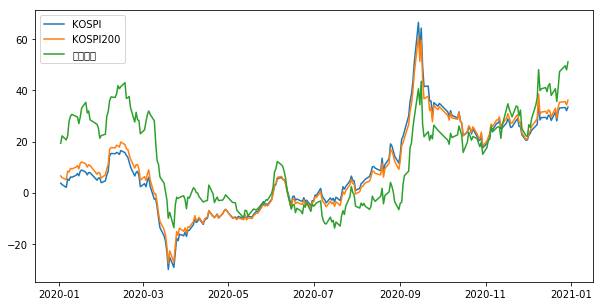

In [33]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)

for k, v in std_list.items():
    name = v['stock_name']
    ticker_data = v['data']
    subplot.plot(ticker_data['prev_rate180'], label=name)
    subplot.legend()
for k, v in ticker_list.items():
    if (k in ["005930.KS"]):
        name = v['stock_name']
        ticker_data = v['data']
        subplot.plot(ticker_data['prev_rate180'], label=name)
        subplot.legend()
plt.show()

## 100기준 수익률 차트

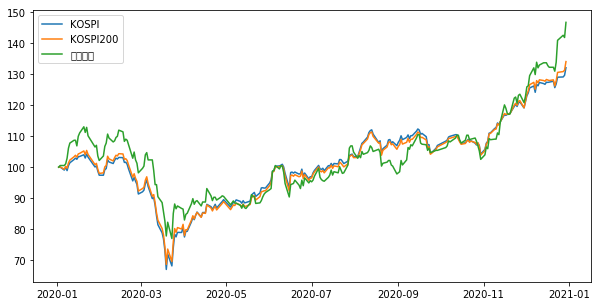

In [34]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)

for k, v in std_list.items():
    name = v['stock_name']
    ticker_data = v['data']
    subplot.plot(ticker_data['relative_value'], label=name)
    subplot.legend()
for k, v in ticker_list.items():
    if (k in ["005930.KS"]):
        name = v['stock_name']
        ticker_data = v['data']
        subplot.plot(ticker_data['relative_value'], label=name)
        subplot.legend()
plt.show()

## 개별 종목 가격, 이동평균 차트

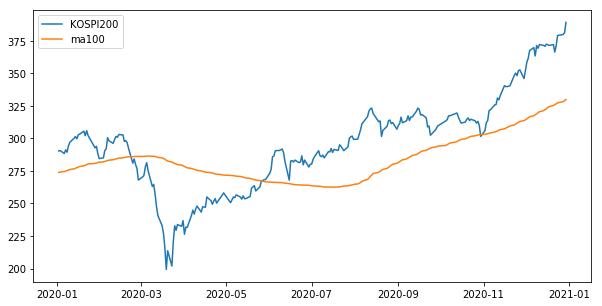

In [19]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)
    
code = "KS200"
ticker_data = std_list[code]['data']
subplot.plot(ticker_data['Close'], label=std_list[code]['stock_name'])
#subplot.plot(ticker_data['ma5'], label='ma5')
#subplot.plot(ticker_data['ma25'], label='ma25')
#subplot.plot(ticker_data['ma50'], label='ma50')
subplot.plot(ticker_data['ma100'], label='ma100')
subplot.legend()
plt.show()

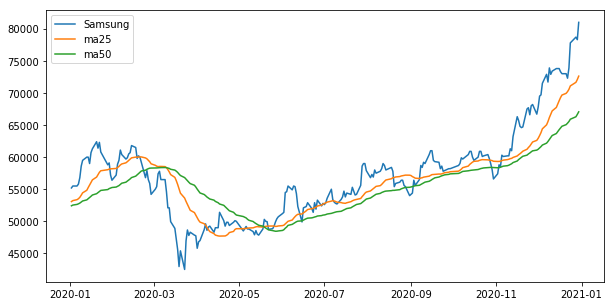

In [20]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)
    
code = "005930.KS"
ticker_data = ticker_list[code]['data']
subplot.plot(ticker_data['Close'], label=ticker_list[code]['stock_name'])
#subplot.plot(ticker_data['ma5'], label='ma5')
subplot.plot(ticker_data['ma25'], label='ma25')
subplot.plot(ticker_data['ma50'], label='ma50')
#subplot.plot(ticker_data['ma100'], label='ma100')
subplot.legend()
plt.show()

# 자산 관리 - 종목 매수, 매도

In [30]:
class Stock:
    def __init__(self, code):
        self.code = code
        self.stock_name = stock_cache.get_stock_name(code)
        self.count = 0
        self.buy_price = 0
        self.price = 0 # current price
        self.ammount = 0
        
    def get_profit_percent(self):
        p = (self.price-self.buy_price)/self.buy_price*100
        return round(p, 2)
    
    def get_profit_amount(self):
        return self.amount - self.buy_price*self.count
        
    def buy(self, count, price):
        self.count += count
        self.buy_price = price
        self.price = price
        self.apply(price)
        
    def sell(self, count, price):
        self.count -= count
        self.price = price
        self.apply(price)
        
    def apply(self, price):
        self.price = price
        self.amount = self.count * self.price
        
class Asset:
    def __init__(self, cash):
        self.stocks = { }
        self.cash = cash
        self.total = cash
    
    def get_stock_count(self):
        return len(self.stocks)
    
    def buy(self, code, count, price):
        stock = self.get_stock(code)
        
        amount = count * price
        self.cash -= amount # TODO cash 부족시
        stock.buy(count, price)
        self.eval()
        
    def get_buy_count(self, price):
        count = math.floor(self.cash / price)
        return count
    
    def sell(self, code, price):
        if (not self.is_stock(code)):
            print("Asset.sell(): stock not exist", code)
            return

        stock = self.get_stock(code)
        count = stock.count
        amount = count * price
        stock.sell(count, price)
        self.cash += amount
        
        if (stock.count == 0):
            del self.stocks[code]
        self.eval()
    
    def apply(self, code, price):
        if (self.is_stock(code)):
            stock = self.get_stock(code)
            stock.apply(price)
            self.eval()
        
    def get_stock(self, code):
        if code in self.stocks:
            return self.stocks[code]
        else:
            stock = Stock(code)
            self.stocks[code] = stock;
            return stock
        
    def is_stock(self, code):
        if code in self.stocks:
            return True
        return False
        
    def eval(self):
        stock_total = 0
        for k, v in self.stocks.items():
            stock_total += v.amount
        self.total = stock_total + self.cash
        return self.total
    
    def display(self):
        print("Asset.display():", "total=", self.total, "cash=", self.cash)
        for k, v in self.stocks.items():
            print("    ", "code=", v.code, "stock_name=", v.stock_name, \
                  "count=", v.count, "price=", v.price, "amount=", v.amount, \
                  "profit_percent=", v.get_profit_percent())


In [8]:
code = "005930.KS"
asset = Asset(10000000)
asset.buy(code, 10, 70000)
asset.apply(code, 80000)
asset.sell(code, 90000)
asset.display()

Asset.display(): total= 10200000 cash= 10200000


# 종목 이벤트 이력

In [17]:
UNKNOWN_TREND = 0
DOWN_TREND = -1
UP_TREND = 1
class StockHistory:
    def __init__(self, code):
        self.code = code
        self.name = stock_cache.get_stock_name(code)
        self.trend = UNKNOWN_TREND
        self.event_histories = [ ]

class StockHistoryStore:
    def __init__(self):
        self.stock_histories = { }
        
    def get_stock_history(self, code):
        if code in self.stock_histories:
            return self.stock_histories[code]
        else:
            stock_history = StockHistory(code)
            self.stock_histories[code] = stock_history;
            return stock_history

# 시스템

In [11]:
batch_data = pd.DataFrame()
idx = '2020-01-02'
for k, v in ticker_list.items():
    copy = v['data'].loc[idx].copy() # ticker_data
    copy['code'] = k
    batch_data = batch_data.append(copy)
batch_filtered_data = batch_data[batch_data.ma25 > batch_data.ma50]
batch_filtered_data.sort_values(by='prev_rate180', ascending=False)

,Adj Close,Close,High,Low,Open,Volume,code,ma100,ma25,ma5,ma50,prev_close180,prev_rate180,relative_value
2020-01-02,1.822389e+05,182500.0,188000.0,182000.0,187500.0,300640.0,035420.KS,159410.0,176600.0,182500.0,169080.0,115000.0,58.695652,100.0
2020-01-02,9.374070e+04,94700.0,96200.0,94100.0,96000.0,2342070.0,000660.KS,81370.0,86276.0,94780.0,84248.0,71400.0,32.633053,100.0
2020-01-02,5.230561e+04,55200.0,56000.0,55000.0,55500.0,12993228.0,005930.KS,49350.0,53078.0,55520.0,52417.0,46250.0,19.351351,100.0
2020-01-02,3.048773e+04,30500.0,30900.0,30400.0,30800.0,1205235.0,035720.KS,28270.0,30480.0,29960.0,29916.0,26300.0,15.969582,100.0
2020-01-02,1.257498e+06,1266000.0,1272000.0,1249000.0,1254000.0,24426.0,051900.KS,1243300.0,1265920.0,1260400.0,1256440.0,1276000.0,-0.783699,100.0


In [585]:
code = "005930.KS"
idx = '2020-01-02'
ticker_data = ticker_list[code]['data']
ticker_data.loc[idx]

High              5.600000e+04
Low               5.500000e+04
Open              5.550000e+04
Close             5.520000e+04
Volume            1.299323e+07
Adj Close         5.230561e+04
prev_close180     4.565000e+04
prev_rate180      2.092004e+01
relative_value    1.000000e+02
ma5               5.558000e+04
ma25              5.323800e+04
ma50              5.253500e+04
ma100             4.945850e+04
Name: 2020-01-02 00:00:00, dtype: float64

In [28]:
class LTHM: # LongTrendHighMomentum
    def __init__(self, max_position=10, max_percent=10, cash=100000000): # 1억원
        self.MAX_POSITION = max_position # 최대 종목 갯수
        self.MAX_PERCENT = max_percent # 전체 자산 대비 종목별 최대 비중
        self.RISK_PERCENT = 2 # 손실 위험
        self.MIN_TRADING_AMOUNT = 60 * 1000 * 1000 * 1200 # 6백억
        self.MIN_PRICE = 6000 # 6천
        self.stock_history_store = StockHistoryStore()
        self.asset = Asset(cash)
        self.data = pd.DataFrame(columns=['total', 'cash'])
        self.action_histories = [ ]
    
    # 모든 종목에 대해 idx row를 합쳐 batch_data 생성
    def make_batch_data(self, idx):
        batch_data = pd.DataFrame()
        for k, v in ticker_list.items():
            if (idx in v['data'].index):
                copy = v['data'].loc[idx].copy()
                copy['code'] = k
                batch_data = batch_data.append(copy)
        return batch_data
    
    def filter_batch_data(self, batch_data):  
        if (len(batch_data) == 0):
            return batch_data
        
        filtered_data = batch_data[\
            (batch_data['Close']*batch_data['Volume'] > self.MIN_TRADING_AMOUNT) &\
            (batch_data['Close'] > self.MIN_PRICE) &\
            (batch_data.ma25 > batch_data.ma50)]
        return filtered_data

        # 종목 거래 금액 filter - 500억 # TODO 20일 기준 일평균 거래 금액 사용
        #new_data = batch_data[batch_data['Close']*batch_data['Volume'] > 50000000000]
        # 종목 주가 filter - 5천원
        #new_data = batch_data[batch_data['Close'] > 5000]
        # 종목 이동 평균 filter
        #new_data = batch_data[batch_data.ma25 > batch_data.ma50]
        #return new_data
    
    def prioritize_batch_data(self, batch_data):
        return batch_data.sort_values(by='prev_rate180', ascending=False)
    
    def backtest(self):
        ticker_data = std_list['KS11']['data'] # idx 가져오기 위해 지수 종목 사용
        for idx, row in ticker_data.iterrows():
            self.apply(idx)
        
        add_relative_value(self.data, 'total') # total 값을 이용하여 relative_value 컬럼 추가
        return
    
    def apply(self, idx):       
        # 신규 종목 체크
        if (self.get_available_position_count() > 0):
            batch_data = self.make_batch_data(idx)
            batch_data = self.filter_batch_data(batch_data)
            batch_data = self.prioritize_batch_data(batch_data)
            #print("LTHM.apply():", "idx=", idx, "batch_data_len=", len(batch_data))
            for idx, row in batch_data.iterrows():
                code = row['code']
                self.apply_stock(code, idx, row)
  
        # 보유 종목 체크
        for k in list(self.asset.stocks.keys()):
            code = k
            ticker_data = ticker_list[code]['data']
            row = ticker_data.loc[idx]
            self.apply_stock(code, idx, row)

        self.data = self.data.append(pd.Series({'total':self.asset.total, 'cash':self.asset.cash}, index=self.data.columns, name=idx))
        
    def apply_stock(self, code, idx, row):
        stock_history = self.stock_history_store.get_stock_history(code)
        price = row['Close']
        self.asset.apply(code, price)
        
        if (self.is_uptrend(stock_history, idx, row) and not self.asset.is_stock(code)):
            count = self.get_buy_count(price)
            if (count > 0):
                action = { "name": "buy", "idx": idx.strftime('%Y-%m-%d'), "code": code, "stock_name": stock_history.name, "count": count, "price": price}
                print("action:", action)
                self.asset.buy(code, count, price)
                self.asset.display()
                self.action_histories.append(action)
        if (self.is_downtrend(stock_history, idx, row) and self.asset.is_stock(code)):
            stock = self.asset.get_stock(code)
            count = stock.count
            if (count > 0):
                self.asset.sell(code, price)
                action = {"name": "sell", \
                          "idx": idx.strftime('%Y-%m-%d'), \
                          "code": code, \
                          "stock_name": stock_history.name, \
                          "count": count, \
                          "price": price, \
                          "buy_price": stock.buy_price, \
                          "profit_percent": stock.get_profit_percent()}
                print("action:", action)
                self.asset.display()
                self.action_histories.append(action)
            
    def get_buy_count(self, price):
        available_position_count = self.get_available_position_count()
#        stock_count = self.asset.get_stock_count()
#        remain_position_count = self.MAX_POSITION - stock_count
        print("LTHM.get_buy_count():", "cash=", self.asset.cash, "available_position_count=", available_position_count)
        
        if (available_position_count < 1):
            return 0
        position_cash = self.asset.cash / available_position_count
        position_limit = self.asset.total * self.MAX_PERCENT / 100
        print("LTHM.get_buy_count():", "position_cash=", position_cash, "position_limit=", position_limit)
        if (position_cash > position_limit):
            position_cash = position_limit
        return math.floor(position_cash / price)
    
    def get_available_position_count(self):
        return self.MAX_POSITION - self.asset.get_stock_count()
    
    def is_uptrend(self, stock_history, idx, row):
        if (row['ma25'] > row['ma50']):
            stock_history.trend = UP_TREND
            return True
        return False        

    def is_downtrend(self, stock_history, idx, row):
        if (row['ma25'] < row['ma50']):
            stock_history.trend = DOWN_TREND
            return True
        return False
    
    def on_gold_cross(self, stock_history, idx, row):
        code = stock_history.code
        stock_name = stock_history.name
        if (stock_history.trend != UP_TREND and row['ma25'] > row['ma50']):
            stock_history.trend = UP_TREND
            event = { "idx": idx.strftime('%Y-%m-%d'), "code": code, "stock_name": stock_name, "name": "uptrend"}
            stock_history.event_histories.append(event)
            print("event:", event)
            return True
        return False
    
    def on_dead_cross(self, stock_history, idx, row):
        code = stock_history.code
        stock_name = stock_history.name
        if (stock_history.trend != DOWN_TREND and row['ma25'] < row['ma50']):
            stock_history.trend = DOWN_TREND
            event = { "idx": idx.strftime('%Y-%m-%d'), "code": code, "stock_name": stock_name, "name": "downtrend"}
            stock_history.event_histories.append(event)
            print("event:", event)
            return True
        return False


## 시스템 - position=1

In [75]:
#ticker_list = ticker_list_one.copy()
system = LTHM(max_position=1, max_percent=100)
system.backtest()
#system.action_histories

event: {'idx': '2020-01-02', 'code': '035420.KS', 'stock_name': 'NAVER', 'name': 'uptrend'}
LTHM.get_buy_count(): cash= 10000000 remain_position_count= 1
LTHM.get_buy_count(): position_cash= 10000000.0 position_limit= 10000000.0
action: {'name': 'buy', 'idx': '2020-01-02', 'code': '035420.KS', 'stock_name': 'NAVER', 'count': 54, 'price': 182500.0}
Asset.display(): total= 10000000.0 cash= 145000.0
event: {'idx': '2020-01-02', 'code': '005490.KS', 'stock_name': 'POSCO', 'name': 'uptrend'}
LTHM.get_buy_count(): cash= 145000.0 remain_position_count= 0
event: {'idx': '2020-01-03', 'code': '105560.KS', 'stock_name': 'KB금융', 'name': 'uptrend'}
LTHM.get_buy_count(): cash= 145000.0 remain_position_count= 0
event: {'idx': '2020-01-07', 'code': '051900.KS', 'stock_name': 'LG생활건강', 'name': 'uptrend'}
LTHM.get_buy_count(): cash= 145000.0 remain_position_count= 0
event: {'idx': '2020-01-08', 'code': '066570.KS', 'stock_name': 'LG전자', 'name': 'uptrend'}
LTHM.get_buy_count(): cash= 145000.0 remain_pos

event: {'idx': '2020-11-30', 'code': '138930.KS', 'stock_name': 'BNK금융지주', 'name': 'uptrend'}
LTHM.get_buy_count(): cash= 9594764.609375 remain_position_count= 1
LTHM.get_buy_count(): position_cash= 9594764.609375 position_limit= 9594764.609375
action: {'name': 'buy', 'idx': '2020-11-30', 'code': '138930.KS', 'stock_name': 'BNK금융지주', 'count': 1704, 'price': 5630.0}
Asset.display(): total= 9594764.609375 cash= 1244.609375
event: {'idx': '2020-12-04', 'code': '082740.KS', 'stock_name': 'HSD엔진', 'name': 'uptrend'}
LTHM.get_buy_count(): cash= 1244.609375 remain_position_count= 0
event: {'idx': '2020-12-09', 'code': '001390.KS', 'stock_name': 'KG케미칼', 'name': 'uptrend'}
LTHM.get_buy_count(): cash= 1244.609375 remain_position_count= 0
event: {'idx': '2020-12-11', 'code': '001120.KS', 'stock_name': 'LX인터내셔널', 'name': 'uptrend'}
LTHM.get_buy_count(): cash= 1244.609375 remain_position_count= 0
event: {'idx': '2020-12-18', 'code': '229640.KS', 'stock_name': 'LS전선아시아', 'name': 'uptrend'}
LTHM.get

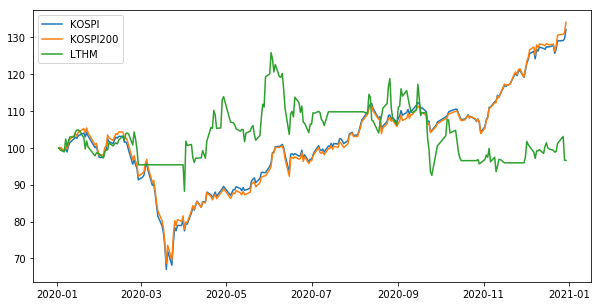

In [76]:
show_chart()

## 시스템 - position=3

In [ ]:
#ticker_list = ticker_list_two.copy()
system = LTHM(max_position=3, max_percent=33)
system.backtest()
#system.apply('2020-01-02')
#system.apply('2020-01-03')
#system.action_histories

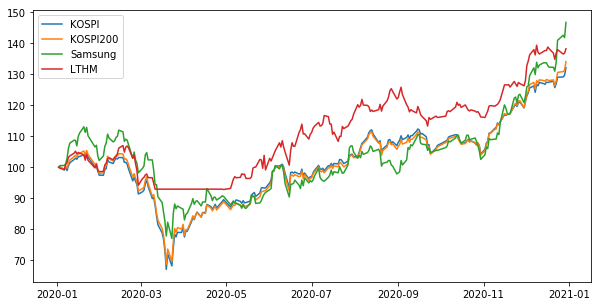

In [31]:
show_chart()

## 시스템 - position=10

In [29]:
system = LTHM(max_position=10, max_percent=10)
system.backtest()

LTHM.get_buy_count(): cash= 100000000 available_position_count= 10
LTHM.get_buy_count(): position_cash= 10000000.0 position_limit= 10000000.0
action: {'name': 'buy', 'idx': '2020-01-02', 'code': '000660.KS', 'stock_name': 'SK하이닉스', 'count': 105, 'price': 94700.0}
Asset.display(): total= 100000000.0 cash= 90056500.0
     code= 000660.KS stock_name= SK하이닉스 count= 105 prict= 94700.0 amount= 9943500.0 profit_percent= 0.0
LTHM.get_buy_count(): cash= 90056500.0 available_position_count= 9
LTHM.get_buy_count(): position_cash= 10006277.777777778 position_limit= 10000000.0
action: {'name': 'buy', 'idx': '2020-01-02', 'code': '005930.KS', 'stock_name': '삼성전자', 'count': 181, 'price': 55200.0}
Asset.display(): total= 100000000.0 cash= 80065300.0
     code= 000660.KS stock_name= SK하이닉스 count= 105 prict= 94700.0 amount= 9943500.0 profit_percent= 0.0
     code= 005930.KS stock_name= 삼성전자 count= 181 prict= 55200.0 amount= 9991200.0 profit_percent= 0.0
LTHM.get_buy_count(): cash= 80065300.0 available_p

LTHM.get_buy_count(): cash= 10792970.0 available_position_count= 1
LTHM.get_buy_count(): position_cash= 10792970.0 position_limit= 10414407.0
action: {'name': 'buy', 'idx': '2020-01-16', 'code': '006400.KS', 'stock_name': '삼성SDI', 'count': 38, 'price': 268500.0}
Asset.display(): total= 104144070.0 cash= 589970.0
     code= 000660.KS stock_name= SK하이닉스 count= 105 prict= 99200.0 amount= 10416000.0 profit_percent= 4.75
     code= 005930.KS stock_name= 삼성전자 count= 181 prict= 60700.0 amount= 10986700.0 profit_percent= 9.96
     code= 035420.KS stock_name= NAVER count= 55 prict= 191500.0 amount= 10532500.0 profit_percent= 5.51
     code= 009150.KS stock_name= 삼성전기 count= 78 prict= 133000.0 amount= 10374000.0 profit_percent= 4.31
     code= 051900.KS stock_name= LG생활건강 count= 7 prict= 1422000.0 amount= 9954000.0 profit_percent= 5.88
     code= 005490.KS stock_name= POSCO count= 44 prict= 242000.0 amount= 10648000.0 profit_percent= 6.14
     code= 066570.KS stock_name= LG전자 count= 153 prict= 6

action: {'name': 'sell', 'idx': '2020-03-04', 'code': '285130.KS', 'stock_name': 'SK케미칼', 'count': 148, 'price': 62100.0, 'buy_price': 69000.0, 'profit_percent': -10.0}
Asset.display(): total= 99806790.0 cash= 17805820.0
     code= 000660.KS stock_name= SK하이닉스 count= 105 prict= 94300.0 amount= 9901500.0 profit_percent= -0.42
     code= 005930.KS stock_name= 삼성전자 count= 181 prict= 57400.0 amount= 10389400.0 profit_percent= 3.99
     code= 009150.KS stock_name= 삼성전기 count= 78 prict= 133000.0 amount= 10374000.0 profit_percent= 4.31
     code= 207940.KS stock_name= 삼성바이오로직스 count= 23 prict= 489000.0 amount= 11247000.0 profit_percent= 12.03
     code= 006400.KS stock_name= 삼성SDI count= 38 prict= 315000.0 amount= 11970000.0 profit_percent= 17.32
     code= 012690.KS stock_name= 모나리자 count= 1295 prict= 5950.0 amount= 7705250.0 profit_percent= -26.45
     code= 026890.KS stock_name= 디피씨 count= 1366 prict= 7770.0 amount= 10613820.0 profit_percent= 5.0
     code= 051910.KS stock_name= LG화학 count

action: {'name': 'sell', 'idx': '2020-03-20', 'code': '207940.KS', 'stock_name': '삼성바이오로직스', 'count': 23, 'price': 430000.0, 'buy_price': 436500.0, 'profit_percent': -1.49}
Asset.display(): total= 76237684.6484375 cash= 35363343.685546875
     code= 006400.KS stock_name= 삼성SDI count= 38 prict= 216500.0 amount= 8227000.0 profit_percent= -19.37
     code= 012690.KS stock_name= 모나리자 count= 1295 prict= 3970.0 amount= 5141150.0 profit_percent= -50.93
     code= 026890.KS stock_name= 디피씨 count= 1366 prict= 3850.0 amount= 5259100.0 profit_percent= -47.97
     code= 051910.KS stock_name= LG화학 count= 25 prict= 272500.0 amount= 6812500.0 profit_percent= -27.72
     code= 023150.KS stock_name= MH에탄올 count= 842 prict= 6750.0 amount= 5683500.0 profit_percent= -38.36
     code= 003000.KS stock_name= 부광약품 count= 606 prict= 16090.9091796875 amount= 9751090.962890625 profit_percent= 6.63
action: {'name': 'sell', 'idx': '2020-03-23', 'code': '006400.KS', 'stock_name': '삼성SDI', 'count': 38, 'price': 2185

LTHM.get_buy_count(): cash= 15903122.685546875 available_position_count= 2
LTHM.get_buy_count(): position_cash= 7951561.3427734375 position_limit= 8673485.133398438
action: {'name': 'buy', 'idx': '2020-04-28', 'code': '035420.KS', 'stock_name': 'NAVER', 'count': 40, 'price': 198000.0}
Asset.display(): total= 86734851.33398438 cash= 7983122.685546875
     code= 023150.KS stock_name= MH에탄올 count= 842 prict= 9180.0 amount= 7729560.0 profit_percent= -16.16
     code= 003000.KS stock_name= 부광약품 count= 606 prict= 24636.36328125 amount= 14929636.1484375 profit_percent= 63.25
     code= 000210.KS stock_name= DL count= 44 prict= 183676.875 amount= 8081782.5 profit_percent= 3.56
     code= 285130.KS stock_name= SK케미칼 count= 97 prict= 77700.0 amount= 7536900.0 profit_percent= -4.07
     code= 006280.KS stock_name= 녹십자 count= 51 prict= 151000.0 amount= 7701000.0 profit_percent= -1.95
     code= 207940.KS stock_name= 삼성바이오로직스 count= 13 prict= 588000.0 amount= 7644000.0 profit_percent= 1.38
     cod

LTHM.get_buy_count(): cash= 14572122.685546875 available_position_count= 2
LTHM.get_buy_count(): position_cash= 7286061.3427734375 position_limit= 10331733.363085937
action: {'name': 'buy', 'idx': '2020-06-12', 'code': '006400.KS', 'stock_name': '삼성SDI', 'count': 19, 'price': 379500.0}
Asset.display(): total= 103317333.63085938 cash= 7361622.685546875
     code= 003000.KS stock_name= 부광약품 count= 606 prict= 35409.08984375 amount= 21457908.4453125 profit_percent= 134.64
     code= 000210.KS stock_name= DL count= 44 prict= 201931.875 amount= 8885002.5 profit_percent= 13.85
     code= 285130.KS stock_name= SK케미칼 count= 97 prict= 96700.0 amount= 9379900.0 profit_percent= 19.38
     code= 207940.KS stock_name= 삼성바이오로직스 count= 13 prict= 805000.0 amount= 10465000.0 profit_percent= 38.79
     code= 003090.KS stock_name= 대웅 count= 469 prict= 29400.0 amount= 13788600.0 profit_percent= 73.45
     code= 035420.KS stock_name= NAVER count= 40 prict= 240500.0 amount= 9620000.0 profit_percent= 21.46
  

LTHM.get_buy_count(): cash= 9988023.146484375 available_position_count= 1
LTHM.get_buy_count(): position_cash= 9988023.146484375 position_limit= 15632288.367773438
action: {'name': 'buy', 'idx': '2020-08-10', 'code': '006120.KS', 'stock_name': 'SK디스커버리', 'count': 148, 'price': 67200.0}
Asset.display(): total= 156322883.67773438 cash= 42423.146484375
     code= 003000.KS stock_name= 부광약품 count= 606 prict= 34681.81640625 amount= 21017180.7421875 profit_percent= 129.82
     code= 285130.KS stock_name= SK케미칼 count= 97 prict= 401500.0 amount= 38945500.0 profit_percent= 395.68
     code= 035420.KS stock_name= NAVER count= 40 prict= 314000.0 amount= 12560000.0 profit_percent= 58.59
     code= 026890.KS stock_name= 디피씨 count= 782 prict= 20300.0 amount= 15874600.0 profit_percent= 99.02
     code= 000020.KS stock_name= 동화약품 count= 441 prict= 29350.0 amount= 12943350.0 profit_percent= 90.58
     code= 006400.KS stock_name= 삼성SDI count= 19 prict= 488000.0 amount= 9272000.0 profit_percent= 28.59
  

LTHM.get_buy_count(): cash= 12657893.388671875 available_position_count= 1
LTHM.get_buy_count(): position_cash= 12657893.388671875 position_limit= 12585509.079882812
action: {'name': 'buy', 'idx': '2020-10-05', 'code': '037270.KS', 'stock_name': 'YG PLUS', 'count': 1790, 'price': 7030.0}
Asset.display(): total= 125855090.79882812 cash= 74193.388671875
     code= 285130.KS stock_name= SK케미칼 count= 97 prict= 296500.0 amount= 28760500.0 profit_percent= 266.05
     code= 035420.KS stock_name= NAVER count= 40 prict= 296500.0 amount= 11860000.0 profit_percent= 49.75
     code= 026890.KS stock_name= 디피씨 count= 782 prict= 15950.0 amount= 12472900.0 profit_percent= 56.37
     code= 000020.KS stock_name= 동화약품 count= 441 prict= 21850.0 amount= 9635850.0 profit_percent= 41.88
     code= 006400.KS stock_name= 삼성SDI count= 19 prict= 433500.0 amount= 8236500.0 profit_percent= 14.23
     code= 051910.KS stock_name= LG화학 count= 15 prict= 654000.0 amount= 9810000.0 profit_percent= 41.56
     code= 19265

LTHM.get_buy_count(): cash= 27597639.888671875 available_position_count= 1
LTHM.get_buy_count(): position_cash= 27597639.888671875 position_limit= 12840877.525
action: {'name': 'buy', 'idx': '2020-10-08', 'code': '011780.KS', 'stock_name': '금호석유', 'count': 91, 'price': 141000.0}
Asset.display(): total= 128408775.25 cash= 14766639.888671875
     code= 026890.KS stock_name= 디피씨 count= 782 prict= 14100.0 amount= 11026200.0 profit_percent= 38.24
     code= 006400.KS stock_name= 삼성SDI count= 19 prict= 439500.0 amount= 8350500.0 profit_percent= 15.81
     code= 051910.KS stock_name= LG화학 count= 15 prict= 680000.0 amount= 10200000.0 profit_percent= 47.19
     code= 192650.KS stock_name= 드림텍 count= 748 prict= 15925.8193359375 amount= 11912512.86328125 profit_percent= 34.73
     code= 006120.KS stock_name= SK디스커버리 count= 148 prict= 64600.0 amount= 9560800.0 profit_percent= -3.87
     code= 034020.KS stock_name= 두산중공업 count= 946 prict= 12745.8974609375 amount= 12057618.998046875 profit_percent= 

LTHM.get_buy_count(): cash= 18336139.888671875 available_position_count= 1
LTHM.get_buy_count(): position_cash= 18336139.888671875 position_limit= 12769972.271484375
action: {'name': 'buy', 'idx': '2020-10-13', 'code': '000270.KS', 'stock_name': '기아', 'count': 253, 'price': 50300.0}
Asset.display(): total= 127699722.71484375 cash= 5610239.888671875
     code= 192650.KS stock_name= 드림텍 count= 748 prict= 15727.9833984375 amount= 11764531.58203125 profit_percent= 33.05
     code= 006120.KS stock_name= SK디스커버리 count= 148 prict= 67500.0 amount= 9990000.0 profit_percent= 0.45
     code= 034020.KS stock_name= 두산중공업 count= 946 prict= 12605.3173828125 amount= 11924630.244140625 profit_percent= -10.33
     code= 037270.KS stock_name= YG PLUS count= 1790 prict= 6230.0 amount= 11151700.0 profit_percent= -11.38
     code= 042670.KS stock_name= 두산인프라코어 count= 453 prict= 28857.0 amount= 13072221.0 profit_percent= 1.93
     code= 009290.KS stock_name= 광동제약 count= 1228 prict= 10500.0 amount= 12894000.0

LTHM.get_buy_count(): cash= 13273766.470703125 available_position_count= 1
LTHM.get_buy_count(): position_cash= 13273766.470703125 position_limit= 12037942.919140626
action: {'name': 'buy', 'idx': '2020-10-22', 'code': '014710.KS', 'stock_name': '사조씨푸드', 'count': 1739, 'price': 6920.0}
Asset.display(): total= 120379429.19140625 cash= 1239886.470703125
     code= 034020.KS stock_name= 두산중공업 count= 946 prict= 13450.0 amount= 12723700.0 profit_percent= -4.32
     code= 037270.KS stock_name= YG PLUS count= 1790 prict= 5140.0 amount= 9200600.0 profit_percent= -26.88
     code= 042670.KS stock_name= 두산인프라코어 count= 453 prict= 28470.5 amount= 12897136.5 profit_percent= 0.57
     code= 009290.KS stock_name= 광동제약 count= 1228 prict= 10200.0 amount= 12525600.0 profit_percent= -2.39
     code= 011780.KS stock_name= 금호석유 count= 91 prict= 137500.0 amount= 12512500.0 profit_percent= -2.48
     code= 066570.KS stock_name= LG전자 count= 140 prict= 90400.0 amount= 12656000.0 profit_percent= -1.63
     code

LTHM.get_buy_count(): cash= 22112796.470703125 available_position_count= 2
LTHM.get_buy_count(): position_cash= 11056398.235351562 position_limit= 11902306.895849602
action: {'name': 'buy', 'idx': '2020-11-05', 'code': '006280.KS', 'stock_name': '녹십자', 'count': 28, 'price': 385000.0}
Asset.display(): total= 119023068.95849602 cash= 11332796.470703125
     code= 042670.KS stock_name= 두산인프라코어 count= 453 prict= 26924.599609375 amount= 12196843.623046875 profit_percent= -4.89
     code= 011780.KS stock_name= 금호석유 count= 91 prict= 134500.0 amount= 12239500.0 profit_percent= -4.61
     code= 066570.KS stock_name= LG전자 count= 140 prict= 86100.0 amount= 12054000.0 profit_percent= -6.31
     code= 000270.KS stock_name= 기아 count= 253 prict= 51500.0 amount= 13029500.0 profit_percent= 2.39
     code= 119650.KS stock_name= KC코트렐 count= 1475 prict= 6993.9653320312 amount= 10316098.86474602 profit_percent= -15.91
     code= 014710.KS stock_name= 사조씨푸드 count= 1739 prict= 6220.0 amount= 10816580.0 prof

LTHM.get_buy_count(): cash= 32763644.224609375 available_position_count= 3
LTHM.get_buy_count(): position_cash= 10921214.741536459 position_limit= 13255750.264746094
action: {'name': 'buy', 'idx': '2020-12-30', 'code': '010060.KS', 'stock_name': 'OCI', 'count': 117, 'price': 93000.0}
Asset.display(): total= 132557502.64746094 cash= 21882644.224609375
     code= 000270.KS stock_name= 기아 count= 253 prict= 62300.0 amount= 15761900.0 profit_percent= 23.86
     code= 119650.KS stock_name= KC코트렐 count= 1475 prict= 9923.8701171875 amount= 14637708.422851562 profit_percent= 19.32
     code= 011200.KS stock_name= HMM count= 1465 prict= 13950.0 amount= 20436750.0 profit_percent= 72.86
     code= 005490.KS stock_name= POSCO count= 52 prict= 270000.0 amount= 14040000.0 profit_percent= 22.73
     code= 006280.KS stock_name= 녹십자 count= 28 prict= 406000.0 amount= 11368000.0 profit_percent= 5.45
     code= 011170.KS stock_name= 롯데케미칼 count= 46 prict= 264500.0 amount= 12167000.0 profit_percent= 7.96
  

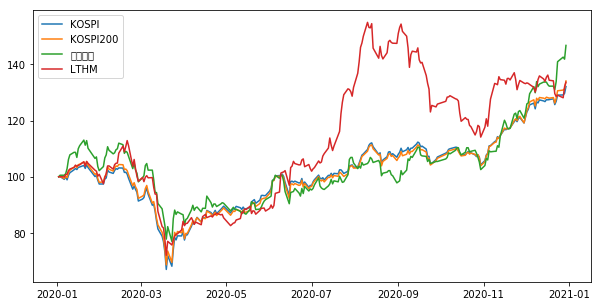

In [31]:
show_chart()

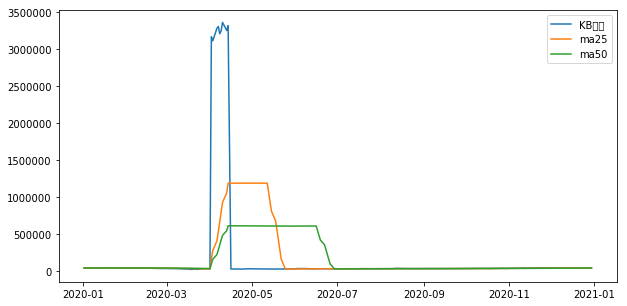

In [108]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)
    
code = '105560.KS'
ticker_data = ticker_list[code]['data']
subplot.plot(ticker_data['Close'], label=ticker_list[code]['stock_name'])
#subplot.plot(ticker_data['ma5'], label='ma5')
subplot.plot(ticker_data['ma25'], label='ma25')
subplot.plot(ticker_data['ma50'], label='ma50')
#subplot.plot(ticker_data['ma100'], label='ma100')
subplot.legend()
plt.show()

In [114]:
ticker_data["2020-03-25":"2020-04-15"]

,High,Low,Open,Close,Volume,Adj Close,prev_close180,prev_rate180,relative_value,ma5,ma25,ma50,ma100
2020-03-25,33300,30550,30600,32000,4002728,3.035460e+04,44000,-27.272727,68.743287,29140.0,35336.0,40079.0,43104.0
2020-03-26,35300,31500,32600,32900,4079253,3.120832e+04,43500,-24.367816,70.676692,30510.0,34964.0,39780.0,43007.0
2020-03-27,35800,34200,35100,35750,3789110,3.391178e+04,43950,-18.657565,76.799141,31490.0,34748.0,39537.0,42940.0
2020-03-30,35500,33750,34300,34750,2529780,3.296320e+04,42400,-18.042453,74.650913,32910.0,34576.0,39272.0,42868.0
2020-03-31,35850,33900,34900,34550,2227158,3.277348e+04,42700,-19.086651,74.221267,33990.0,34388.0,39005.0,42790.5
2020-04-01,34150,31600,33450,31600,2918796,2.997517e+04,42500,-25.647059,67.883996,33910.0,34090.0,38671.0,42674.5
2020-04-02,3230000,3055000,3190000,3170000,2356609,3.007003e+06,41850,7474.671446,6809.881847,661330.0,159314.0,101124.0,73935.0
2020-04-03,3225000,3090000,3115000,3115000,2312886,2.954830e+06,41650,7378.991597,6691.729323,1277180.0,282358.0,162473.0,104652.5
2020-04-06,3285000,3115000,3165000,3285000,1998703,3.116089e+06,41250,7863.636364,7056.928034,1927230.0,412222.0,227239.0,137070.5
2020-04-07,3410000,3240000,3355000,3310000,2588831,3.139804e+06,41700,7837.649880,7110.633727,2582320.0,543098.0,292549.0,169737.5
